In [354]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# the methods to look into during comparison
methods = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),    
    ]

The feature engeneering: 

In [355]:
import pandas
input_dataframe = pandas.read_csv("train.csv")

In [356]:
input_dataframe.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [357]:
input_dataframe['Age'].fillna(input_dataframe['Age'].median(), inplace = True)
input_dataframe['Embarked'].fillna(input_dataframe['Embarked'].mode()[0], inplace = True)
input_dataframe['Fare'].fillna(input_dataframe['Fare'].median(), inplace = True)

In [358]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
input_dataframe["Embarked"] = le.fit_transform(input_dataframe["Embarked"].astype(str))
input_dataframe["Cabin"] = le.fit_transform(input_dataframe["Cabin"].astype(str))
input_dataframe["Sex"] = le.fit_transform(input_dataframe["Sex"].astype(str))

In [359]:
# add feature of being in the same cabin (travelling alone)
# Create new feature FamilySize as a combination of SibSp and Parch
input_dataframe['FamilySize'] = input_dataframe['SibSp'] + input_dataframe['Parch'] + 1
# Create new feature IsAlone from FamilySize
input_dataframe['IsAlone'] = 0
input_dataframe.loc[input_dataframe['FamilySize'] == 1, 'IsAlone'] = 1


# Mapping Fare
input_dataframe.loc[ input_dataframe['Fare'] <= 7.91, 'Fare'] = 0
input_dataframe.loc[(input_dataframe['Fare'] > 7.91) & (input_dataframe['Fare'] <= 14.454), 'Fare'] = 1
input_dataframe.loc[(input_dataframe['Fare'] > 14.454) & (input_dataframe['Fare'] <= 31), 'Fare']   = 2
input_dataframe.loc[ input_dataframe['Fare'] > 31, 'Fare'] = 3
input_dataframe['Fare'] = input_dataframe['Fare'].astype(int)

# Mapping Age
input_dataframe.loc[input_dataframe['Age'] <= 16, 'Age'] = 0
input_dataframe.loc[(input_dataframe['Age'] > 16) & (input_dataframe['Age'] <= 32), 'Age'] = 1
input_dataframe.loc[(input_dataframe['Age'] > 32) & (input_dataframe['Age'] <= 48), 'Age'] = 2
input_dataframe.loc[(input_dataframe['Age'] > 48) & (input_dataframe['Age'] <= 64), 'Age'] = 3
input_dataframe.loc[input_dataframe['Age'] > 64, 'Age'] = 4

In [360]:
input_dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,0,147,2,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,PC 17599,3,81,0,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,1.0,0,0,STON/O2. 3101282,1,147,2,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,113803,3,55,2,2,0
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,1,147,2,1,1


In [361]:
#set(input_dataframe['Ticket'])

In [362]:
def regex(column):
    import re

    matches = []
    for row in column:
        match = re.match('.* ', row)
        if match!=None:
            rematch = match[0]
            for character in ['.', '/', ' ']:
                rematch = rematch.replace(character, "", 10)

            #print(rematch)
            matches.append(rematch)
        else:
            matches.append('no match')
            
    return matches

In [363]:
def regex_name(column):
    import re

    matches = []
    for row in column:
        match = re.match('.*,', row)
        if match!=None:
            rematch = match[0]
            #print(rematch)
            matches.append(rematch)
        else:
            matches.append('no match')
            
    return matches

In [364]:
input_dataframe['Ticket'] = regex(input_dataframe['Ticket'])
input_dataframe['Name'] = regex_name(input_dataframe['Name'])   

In [365]:
set(input_dataframe['Name'])
input_dataframe['Name'] = le.fit_transform(input_dataframe['Name'].astype(str))

In [366]:
input_dataframe['Ticket']

0            A5
1            PC
2        STONO2
3      no match
4      no match
         ...   
886    no match
887    no match
888          WC
889    no match
890    no match
Name: Ticket, Length: 891, dtype: object

In [367]:
input_dataframe['Ticket'] = le.fit_transform(input_dataframe['Ticket'].astype(str))

In [368]:
input_dataframe['Ticket']

0       1
1       9
2      25
3      29
4      29
       ..
886    29
887    29
888    27
889    29
890    29
Name: Ticket, Length: 891, dtype: int64

In [369]:
input_dataframe.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize',
       'IsAlone'],
      dtype='object')

In [370]:
input_dataframe.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0,3,73,1,1.0,1,0,1,0,147,2,2,0
1,2,1,1,136,0,2.0,1,0,9,3,81,0,2,0


In [371]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = input_dataframe.corr()

<AxesSubplot:>

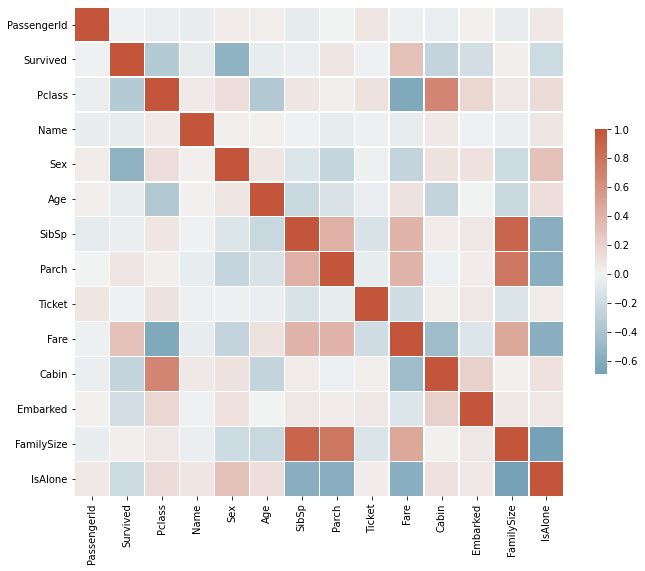

In [372]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# pclass, sex, fare, cabin, embarked, family size, is alone

get to categorical data

In [373]:
matX = input_dataframe[['Pclass', 'Name', 'Sex', 'SibSp', 'Age', 
       'Parch', 'Fare', 'Cabin', 'Embarked', 'FamilySize',
       'IsAlone']]

# 'Ticket'

In [374]:
from sklearn import model_selection
labels = input_dataframe['Survived']
train, test, labels_train, labels_test = model_selection.train_test_split(matX, labels, random_state = 0, test_size=0.5)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
fitted = clf.fit(train, labels_train)
predicted_labels = fitted.predict(test)

from sklearn.metrics import accuracy_score

accuracy_score(predicted_labels, labels_test)

0.8139013452914798

In [375]:
import warnings
# some of the methods do no converge
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import numpy as np

dict_cv = {}

for method in methods:
    clf = method.fit(train, labels_train)
    predicted_labels = clf.predict(test)
    cv_results = model_selection.cross_validate(method, train, labels_train, cv  = 3)
    
    dict_cv[method]=np.mean(cv_results['test_score'])

In [376]:
print(dict_cv)

{AdaBoostClassifier(): 0.7371213495374569, BaggingClassifier(): 0.7348237499244211, ExtraTreesClassifier(): 0.7257391619807727, GradientBoostingClassifier(): 0.7618356611645202, RandomForestClassifier(): 0.7144779007195114, GaussianProcessClassifier(): 0.5708476933309149, LogisticRegressionCV(): 0.7865802043654392, PassiveAggressiveClassifier(): 0.609030171110708, RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])): 0.8045377592357458, SGDClassifier(): 0.5866588064574642, Perceptron(): 0.6224076425418708, BernoulliNB(): 0.7526754942862325, GaussianNB(): 0.7640879134167724, KNeighborsClassifier(): 0.5955922365318339, SVC(probability=True): 0.6403803131991052, NuSVC(probability=True): 0.6135800229759961, LinearSVC(): 0.6741338654090332, DecisionTreeClassifier(): 0.6988481770360965, ExtraTreeClassifier(): 0.692182115000907, LinearDiscriminantAnalysis(): 0.8045377592357458, QuadraticDiscriminantAnalysis(): 0.7012667029445553}


In [377]:
max_key = max(dict_cv, key=dict_cv.get)

In [378]:
max_key

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))

Now time to apply it to the test .csv

In [379]:
test_dataframe = pandas.read_csv("test.csv")

In [380]:
test_dataframe["Embarked"] = le.fit_transform(test_dataframe["Embarked"].astype(str))
test_dataframe["Cabin"] = le.fit_transform(test_dataframe["Cabin"].astype(str))
test_dataframe["Sex"] = le.fit_transform(test_dataframe["Sex"].astype(str))
test_dataframe['Age'].fillna(test_dataframe['Age'].median(), inplace = True)
test_dataframe['Embarked'].fillna(test_dataframe['Embarked'].mode()[0], inplace = True)
test_dataframe['Fare'].fillna(test_dataframe['Fare'].median(), inplace = True)

test_dataframe['FamilySize'] = test_dataframe['SibSp'] + test_dataframe['Parch'] + 1
# Create new feature IsAlone from FamilySize
test_dataframe['IsAlone'] = 0
test_dataframe.loc[test_dataframe['FamilySize'] == 1, 'IsAlone'] = 1


# Mapping Fare
test_dataframe.loc[ test_dataframe['Fare'] <= 7.91, 'Fare'] = 0
test_dataframe.loc[(test_dataframe['Fare'] > 7.91) & (test_dataframe['Fare'] <= 14.454), 'Fare'] = 1
test_dataframe.loc[(test_dataframe['Fare'] > 14.454) & (test_dataframe['Fare'] <= 31), 'Fare']   = 2
test_dataframe.loc[ test_dataframe['Fare'] > 31, 'Fare'] = 3
test_dataframe['Fare'] = test_dataframe['Fare'].astype(int)

# Mapping Age
test_dataframe.loc[test_dataframe['Age'] <= 16, 'Age'] = 0
test_dataframe.loc[(test_dataframe['Age'] > 16) & (test_dataframe['Age'] <= 32), 'Age'] = 1
test_dataframe.loc[(test_dataframe['Age'] > 32) & (test_dataframe['Age'] <= 48), 'Age'] = 2
test_dataframe.loc[(test_dataframe['Age'] > 48) & (test_dataframe['Age'] <= 64), 'Age'] = 3
test_dataframe.loc[test_dataframe['Age'] > 64, 'Age'] = 4

test_dataframe['Ticket'] = regex(test_dataframe['Ticket'])
test_dataframe['Name'] = regex_name(test_dataframe['Name']) 
test_dataframe['Ticket'] = le.fit_transform(test_dataframe['Ticket'].astype(str))
test_dataframe['Name'] = le.fit_transform(test_dataframe['Name'].astype(str))

In [381]:
matTest = test_dataframe[['Pclass', 'Name', 'Sex', 'SibSp', 'Age', 
       'Parch', 'Fare', 'Cabin', 'Embarked', 'FamilySize',
       'IsAlone']]

In [382]:
# train on the full data matX
#fitted.fit(matX, labels)
predicted_labels = fitted.predict(matTest)
#print('accuracy', accuracy_score(labels_test, predicted_labels)) - we don't have the true labels from test set

In [383]:
array = np.array([test_dataframe['PassengerId'], predicted_labels])
result_random_forest = pandas.DataFrame(array.T, columns=['PassengerId', "Survived"])

In [384]:
result_random_forest.to_csv('submissions/RandomForestPclassNameSexSibSpAgeParchFareCabinEmbarkedFamilySizeIsAlone.csv',index=False)